# **Descriptive Analytics**

In [11]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

In [12]:
# read csv files
try:
    charging_sessions_df = pd.read_csv('resources/charging_sessions_cleaned.csv')
    print("Successfully imported charging_sessions.csv")
except FileNotFoundError:
    print("Error: charging_sessions.csv not found.")

try:
    weather_burbank_airport_df = pd.read_csv('resources/weather_data_cleaned.csv')
    print("Successfully imported weather_burbank_airport.csv")
except FileNotFoundError:
    print("Error: weather_burbank_airport.csv not found.")

Successfully imported charging_sessions.csv
Successfully imported weather_burbank_airport.csv


In [13]:
charging_sessions_df.describe()

,kWhDelivered,siteID,userID,kWhRequested,minutesAvailable,milesRequested,WhPerMile,kWh_delivered_requested_diff
count,65037.000000,65037.000000,47822.000000,47822.000000,47822.000000,47822.000000,47822.000000,47822.000000
mean,11.734288,1.482925,1821.825457,25.088483,357.474091,74.350320,361.442871,11.652341
std,10.278928,0.499712,2647.909756,20.786302,196.298027,62.172469,101.930111,16.577657
min,0.501000,1.000000,1.000000,0.000000,1.000000,0.000000,50.000000,-73.709242
25%,5.060000,1.000000,436.000000,12.000000,193.000000,30.000000,288.000000,2.802250
50%,9.099000,1.000000,826.000000,18.780000,360.000000,50.000000,357.000000,6.535000
75%,14.127000,2.000000,1813.000000,32.000000,497.000000,100.000000,400.000000,14.567000
max,108.797242,2.000000,19923.000000,215.320000,10062.000000,775.000000,2000.000000,213.686000


In [17]:
charging_sessions_df['connectionTime'] = pd.to_datetime(charging_sessions_df['connectionTime'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
charging_sessions_df['disconnectTime'] = pd.to_datetime(charging_sessions_df['disconnectTime'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
charging_sessions_df['doneChargingTime'] = pd.to_datetime(charging_sessions_df['doneChargingTime'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
charging_sessions_df['modifiedAt'] = pd.to_datetime(charging_sessions_df['modifiedAt'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
charging_sessions_df['requestedDeparture'] = pd.to_datetime(charging_sessions_df['requestedDeparture'], utc=True, errors='coerce').dt.tz_convert('America/Los_Angeles')
charging_sessions_df.dtypes

id                                                           object
connectionTime                  datetime64[ns, America/Los_Angeles]
disconnectTime                  datetime64[ns, America/Los_Angeles]
doneChargingTime                datetime64[ns, America/Los_Angeles]
kWhDelivered                                                float64
sessionID                                                    object
siteID                                                        int64
spaceID                                                      object
stationID                                                    object
userID                                                      float64
kWhRequested                                                float64
requestedDeparture              datetime64[ns, America/Los_Angeles]
minutesAvailable                                            float64
milesRequested                                              float64
modifiedAt                      datetime64[ns, A

## **Temporal Patterns and Seasonality**

After having prepared the data for further use, we want to analyze how the number of charging events varies during the day, the week, and between seasons.

### **Variation during the day**

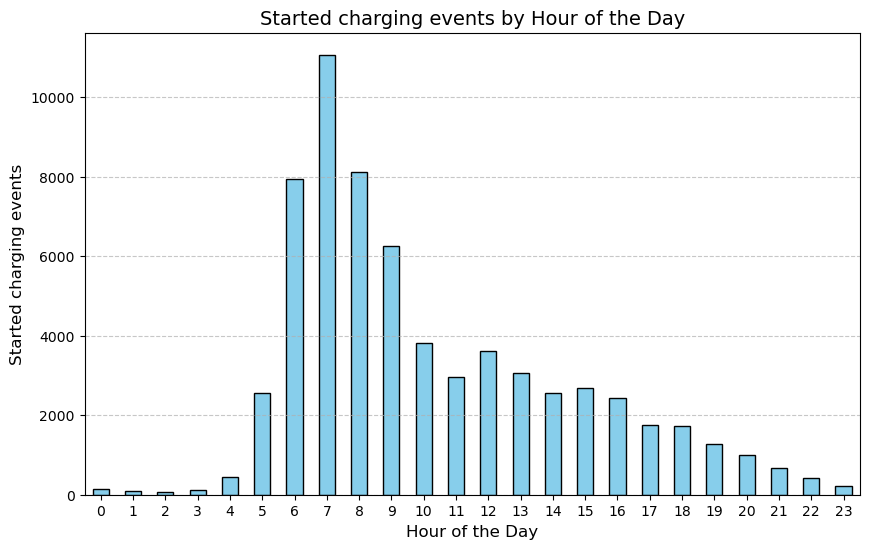

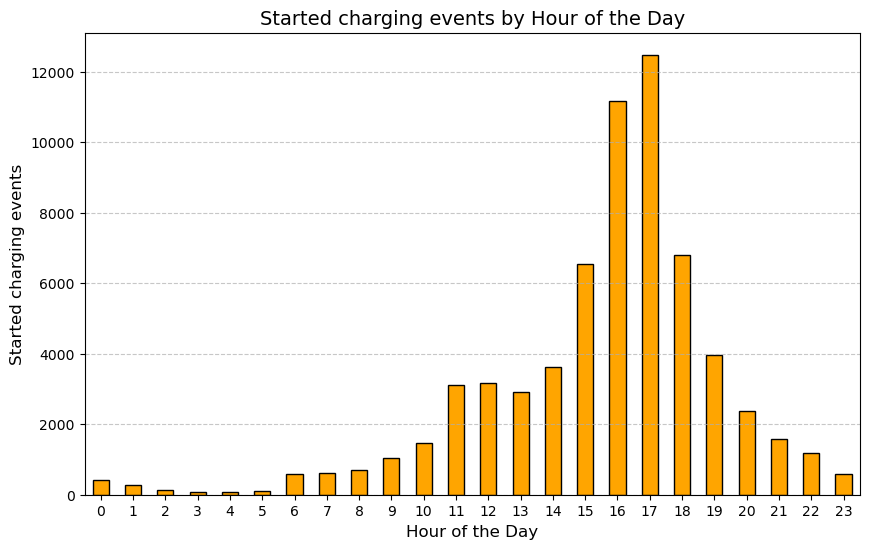

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,minutesAvailable,milesRequested,modifiedAt,WhPerMile,connectionDuration,chargingDuration,noChargingTime,kWh_delivered_requested_diff,connectionHour,disconnectHour
0,5e23b149f9af8b5fe4b973cf,2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,463.0,100.0,2020-01-02 05:09:39-08:00,250.0,0 days 06:02:21,0 days 04:22:41,0 days 01:39:40,-0.016,5,11
1,5e23b149f9af8b5fe4b973d0,2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,595.0,250.0,2020-01-02 05:37:11-08:00,280.0,0 days 09:01:31,0 days 06:41:15,0 days 02:20:16,36.903,5,14
2,5e23b149f9af8b5fe4b973d1,2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,60.0,20.0,2020-01-02 05:57:17-08:00,400.0,0 days 10:42:47,0 days 02:38:31,0 days 08:04:16,1.479,5,16
3,5e23b149f9af8b5fe4b973d2,2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,...,65.0,20.0,2020-01-02 06:00:03-08:00,400.0,0 days 02:38:41,0 days 01:18:47,0 days 01:19:54,5.645,5,8
4,5e23b149f9af8b5fe4b973d3,2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,...,504.0,40.0,2020-01-02 06:00:13-08:00,400.0,0 days 08:08:39,0 days 04:17:29,0 days 03:51:10,2.625,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65032,5d2fbdd3f9af8b4d0dd0d54a,2019-07-01 14:49:12-07:00,2019-07-01 18:37:18-07:00,2019-07-01 16:14:33-07:00,8.399,1_1_179_798_2019-07-01 21:49:11.873404,1,AG-3F18,1-1-179-798,1346.0,...,36.0,80.0,2019-07-01 14:49:37-07:00,400.0,0 days 03:48:06,0 days 01:25:21,0 days 02:22:45,23.601,14,18
65033,5d2fbdd3f9af8b4d0dd0d54b,2019-07-01 14:58:45-07:00,2019-07-01 17:39:48-07:00,2019-07-01 17:40:21-07:00,16.864,1_1_179_794_2019-07-01 21:58:44.571011,1,AG-3F20,1-1-179-794,364.0,...,234.0,100.0,2019-07-01 14:59:09-07:00,400.0,0 days 02:41:03,0 days 02:41:36,0 days 00:00:33,23.136,14,17
65034,5d2fbdd3f9af8b4d0dd0d54c,2019-07-01 15:02:21-07:00,2019-07-01 17:58:50-07:00,2019-07-01 17:59:23-07:00,18.335,1_1_191_807_2019-07-01 22:02:20.810735,1,AG-4F47,1-1-191-807,2050.0,...,309.0,90.0,2019-07-01 15:02:37-07:00,333.0,0 days 02:56:29,0 days 02:57:02,0 days 00:00:33,11.635,15,17
65035,5d2fbdd3f9af8b4d0dd0d54d,2019-07-01 15:23:44-07:00,2019-07-01 19:03:36-07:00,2019-07-01 19:04:06-07:00,22.815,1_1_179_781_2019-07-01 22:23:32.496137,1,AG-3F31,1-1-179-781,1626.0,...,99.0,170.0,2019-07-01 15:23:43-07:00,200.0,0 days 03:39:52,0 days 03:40:22,0 days 00:00:30,11.185,15,19


In [22]:
charging_sessions_df['connectionHour'] = charging_sessions_df['connectionTime'].dt.hour
hourly_connection_counts = charging_sessions_df.groupby('connectionHour').size()
charging_sessions_df['disconnectHour'] = charging_sessions_df['disconnectTime'].dt.hour
hourly_disconnect_counts = charging_sessions_df.groupby('disconnectHour').size()

plt.figure(figsize=(10, 6))
hourly_connection_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Started charging events by Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Started charging events', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10, 6))
hourly_disconnect_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Started charging events by Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Started charging events', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

charging_sessions_df

As we can see in the figure above, the majority of the charging sessions are started in early hours of the day (6am-8am). We can explain this with most peoples 
schedule being that they arrive at work / uni in the morning. They would then leave their car for charging and go on with their day. Less and less people arrive at the sites then later in the day, which is why the amount of chargings declines.

### **Variation during the week**

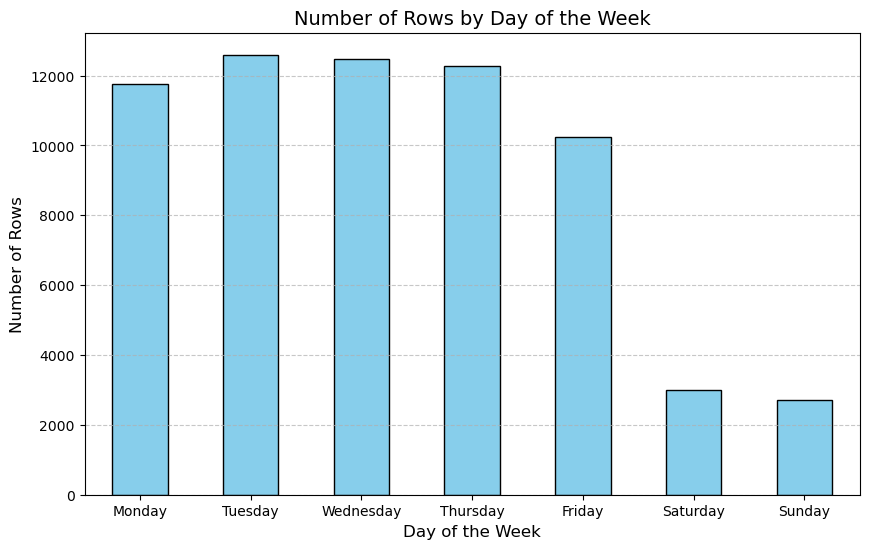

In [23]:
charging_sessions_df['weekDay'] = charging_sessions_df['connectionTime'].dt.weekday
weekly_counts = charging_sessions_df.groupby('weekDay').size()
weekday_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
weekly_counts.index = weekly_counts.index.map(lambda x: weekday_mapping[x])

plt.figure(figsize=(10, 6))
weekly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Rows by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that the amount of charging events remain mostly stable during the working week, with slightly lower values on Monday and Friday. This could be caused by the fact that people prefer working from home right before / after the weekend or some students prefer to stay at home instead of using their car to get to work / uni. Further, we see a massive drop in the values on Saturday and Sunday. A reason for this could be that most people don't have to commute to work / university / school and just stay at home on the weekend without using their cars.

### **Variation between Seasons**

Now we want to inspect the variation between the different seasons. In order to have comparable results, we will restrict ourselves on the year 2019 so each season appears once.

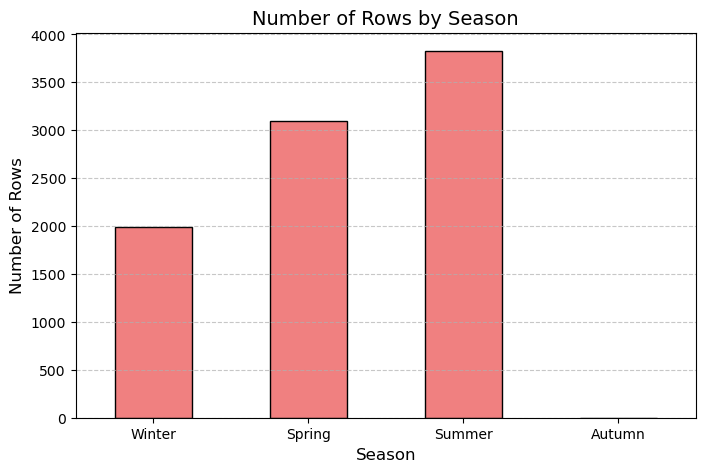

In [24]:
def get_season(date):
    if (date.month == 12 and date.day >= 21) or date.month in [1, 2] or (date.month == 3 and date.day <= 19):
        return 'Winter'
    elif (date.month == 3 and date.day >= 20) or date.month in [4, 5] or (date.month == 6 and date.day <= 20):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or date.month in [7, 8] or (date.month == 9 and date.day <= 21):
        return 'Summer'
    elif (date.month == 9 and date.day >= 22) or date.month in [10, 11] or (date.month == 12 and date.day <= 20):
        return 'Autumn'


charging_sessions_df_2019 = charging_sessions_df[charging_sessions_df['connectionTime'].between('2021-01', '2021-12')].copy(deep=True)
charging_sessions_df_2019['season'] = charging_sessions_df_2019['connectionTime'].apply(get_season)
seasonal_counts = charging_sessions_df_2019['season'].value_counts()
seasonal_counts = seasonal_counts.reindex(['Winter', 'Spring', 'Summer', 'Autumn'], fill_value=0)

plt.figure(figsize=(8, 5))
seasonal_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Number of Rows by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We observe that the most charging events happen in Spring, followed by Summer. An explanation could be that people perceive the weather as 'nicer' and warmer in those seasons and are more willing to go outside, go on trips and go on vacation, which is why they use their cars more often. In contrast, the weather in Autumn and Winter might be perceived as colder and worse, which is why people would prefer staying at home and not use their car.

## **Key Performance Indicators**

We have chosen the following **Key Performance Indicators**

1. **Active Sessions**
- The number of charging sessions currently active
- This KPI gives us an immediate overview of how many charging sessions are happening at the same time, thus giving us an insight into the hub’s utilization. A consistently high number of active sessions means a high demand, while a low count might hint at underutilization. Monitoring this could help the operator identify peak usage times and optimize resources

2. **Delivered vs. Requested Energy Percentage**
- The percentage of energy delivered to the energy requested in completed charging sessions
- This KPI shows us whether the hubs are able to meet the customers demands for energy. A low percentage means inefficiencies or limitations in energy delivery. A high percentage suggests efficient energy delivery. If the customer does not receive the requested energy, then they will be unsatisfied with the service. Thus, in a way, this metric also reflects the customers satisfaction.

3. **Cumulative Energy Delivered**
- The cumulative amount of energy delivered (aggregated hourly)
- This KPI visualizes the total energy consumption over time, giving us an understanding of the hubs energy throughput. A strongly rising graph shows an increasing demand, while a slow rising (or even non-rising) means low demand

4. **Average Session Duration**
- The average charging session duration
- This KPI denotes customer behavior and helps to identify charging trends. Longer durations could indicate that customers are leaving vehicles unattended or slow charging rates, while shorter durations on the other hand might reflect faster charging for vehicles. This information is useful for understanding customer needs and optimizing station availability.

<Figure size 1000x600 with 0 Axes>

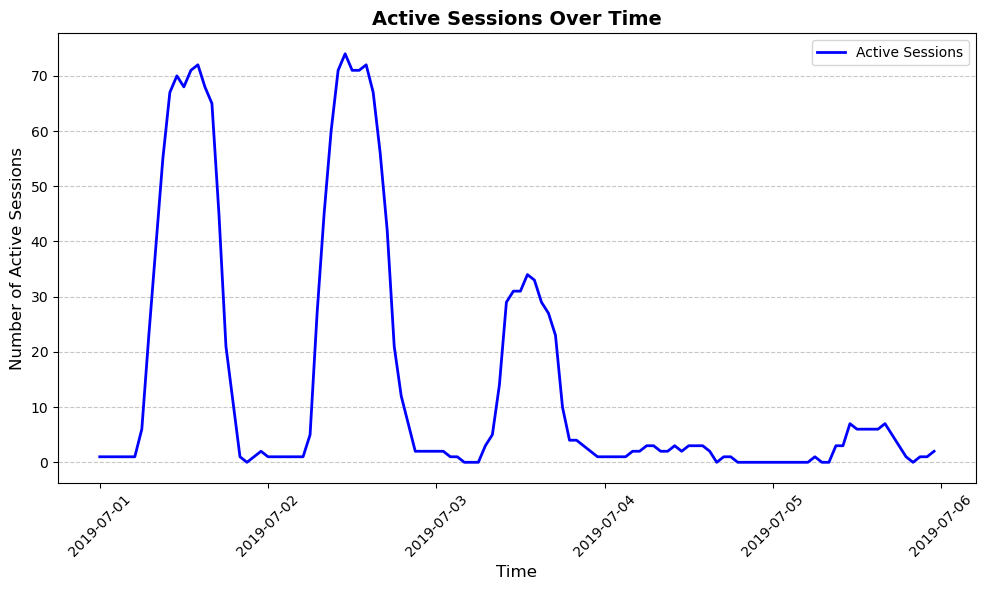

<Figure size 1000x600 with 0 Axes>

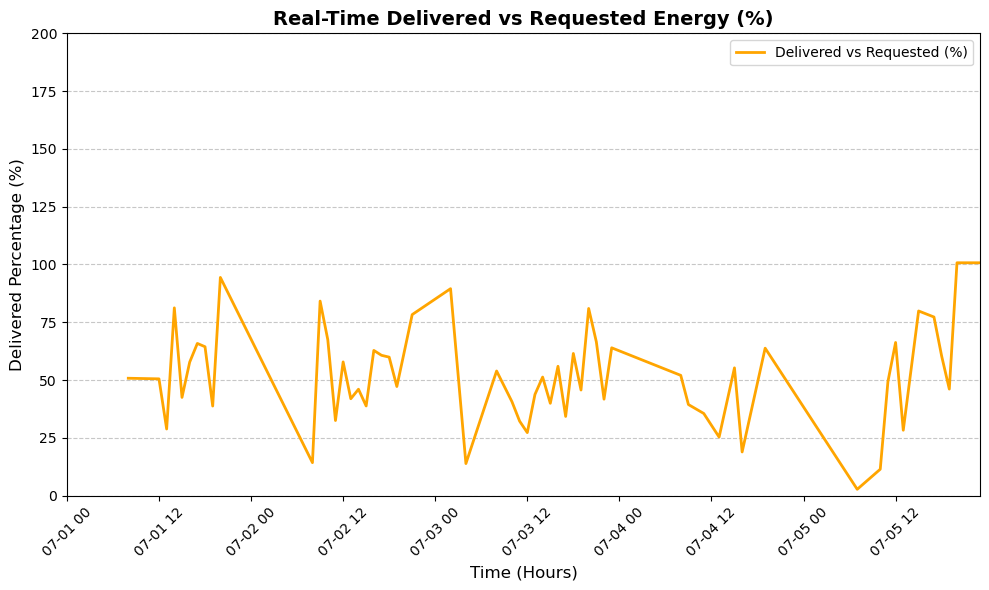

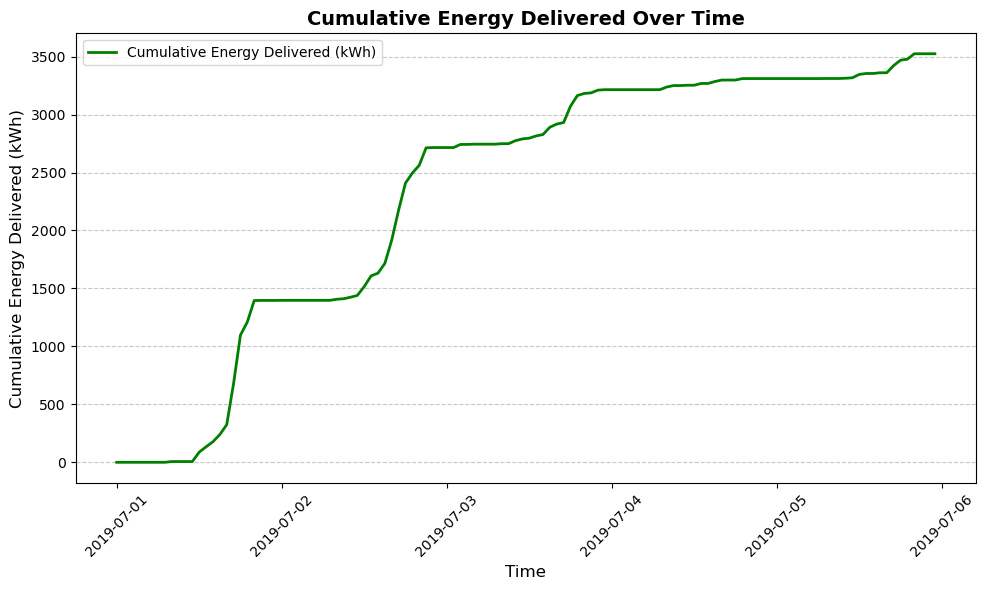

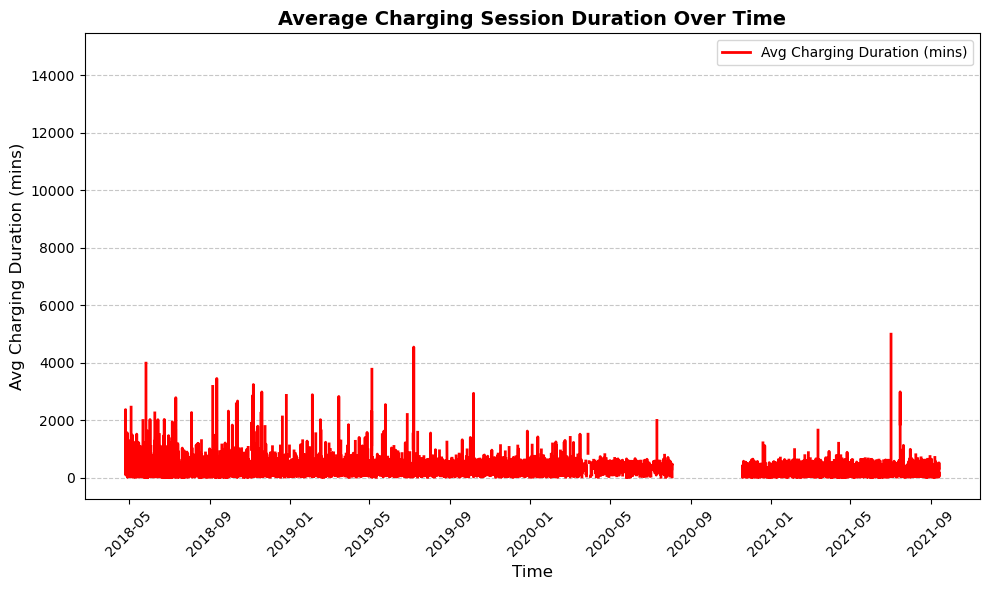

In [72]:
## charging_sessions_kpi_df = charging_sessions_df.copy(deep=True)
charging_sessions_kpi_df = charging_sessions_kpi_df.sort_values(by='disconnectTime')

time_range = pd.date_range('2019-07-01 00:00:00', '2019-07-05 23:59:59', freq='h', tz='America/Los_Angeles')
filtered_sessions = charging_sessions_kpi_df[
    (charging_sessions_kpi_df['disconnectTime'] <= time_range[-1]) &
    (charging_sessions_kpi_df['connectionTime'] >= time_range[0])
].copy()

active_sessions = []

delivered_energy = []
delivered_sum = 0
real_time_percentage = []

for time_point in time_range:
    active_count = charging_sessions_kpi_df[
        (charging_sessions_kpi_df['connectionTime'] <= time_point) &
        (charging_sessions_kpi_df['disconnectTime'] > time_point)
    ].shape[0]
    active_sessions.append(active_count)
    
    ended_sessions = filtered_sessions[
        filtered_sessions['disconnectTime'] <= time_point
    ]
    requested = ended_sessions['kWhRequested'].sum()
    delivered = ended_sessions['kWhDelivered'].sum()
    delivered_sum += delivered
    filtered_sessions = filtered_sessions[
        filtered_sessions['disconnectTime'] > time_point
    ]
    if requested > 0:
        percentage = (delivered / requested) * 100
    else:
        percentage = None
    real_time_percentage.append(percentage)
    delivered_energy.append(delivered_sum)

results_df = pd.DataFrame({
    'time': time_range,
    'activeSessions': active_sessions,
    'deliveredPercentage': real_time_percentage,
    'deliveredTotal': delivered_energy
}).set_index('time')

plt.figure(figsize=(10, 6))

charging_sessions_kpi_df['sessionDuration'] = (
    (charging_sessions_df['disconnectTime'] - charging_sessions_df['connectionTime'])
    .dt.total_seconds() / 60
)
hourly_data = charging_sessions_kpi_df.resample('h', on='connectionTime').agg({
    'sessionDuration': 'sum',
    'sessionID': 'count'
}).rename(columns={'sessionID': 'sessionCount'})
hourly_data['avgSessionDuration'] = hourly_data['sessionDuration'] / hourly_data['sessionCount']

plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['activeSessions'], label='Active Sessions', color='blue', linewidth=2)
plt.title('Active Sessions Over Time', fontsize=14, weight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Active Sessions', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Interpolate missing values to connect points
results_df['deliveredPercentage'] = results_df['deliveredPercentage'].interpolate(method='linear')

plt.figure(figsize=(10, 6))

# Plot the line
plt.plot(results_df.index, results_df['deliveredPercentage'], label='Delivered vs Requested (%)', color='orange', linewidth=2)
plt.title('Real-Time Delivered vs Requested Energy (%)', fontsize=14, weight='bold')
plt.ylabel('Delivered Percentage (%)', fontsize=12)
plt.xlabel('Time (Hours)', fontsize=12)
plt.xlim(results_df.index.min(), results_df.index.max())
plt.ylim(0, 200)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['deliveredTotal'], label='Cumulative Energy Delivered (kWh)', color='green', linewidth=2)
plt.title('Cumulative Energy Delivered Over Time', fontsize=14, weight='bold')
plt.ylabel('Cumulative Energy Delivered (kWh)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hourly_data.index, hourly_data['avgSessionDuration'], label='Avg Charging Duration (mins)', color='red', linewidth=2)
plt.title('Average Charging Session Duration Over Time', fontsize=14, weight='bold')
plt.ylabel('Avg Charging Duration (mins)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [69]:
results_df.transpose().loc["deliveredPercentage"]

time
2019-02-01 00:00:00-08:00          NaN
2019-02-01 01:00:00-08:00          NaN
2019-02-01 02:00:00-08:00          NaN
2019-02-01 03:00:00-08:00          NaN
2019-02-01 04:00:00-08:00          NaN
2019-02-01 05:00:00-08:00          NaN
2019-02-01 06:00:00-08:00          NaN
2019-02-01 07:00:00-08:00          NaN
2019-02-01 08:00:00-08:00          NaN
2019-02-01 09:00:00-08:00          NaN
2019-02-01 10:00:00-08:00    65.026667
2019-02-01 11:00:00-08:00    37.635786
2019-02-01 12:00:00-08:00    46.636319
2019-02-01 13:00:00-08:00    82.431034
2019-02-01 14:00:00-08:00    61.643047
2019-02-01 15:00:00-08:00    48.405983
2019-02-01 16:00:00-08:00    53.420853
2019-02-01 17:00:00-08:00    68.619110
2019-02-01 18:00:00-08:00    66.866132
2019-02-01 19:00:00-08:00    49.188804
2019-02-01 20:00:00-08:00    48.610932
2019-02-01 21:00:00-08:00    95.572917
2019-02-01 22:00:00-08:00    73.200549
2019-02-01 23:00:00-08:00    31.291667
Name: deliveredPercentage, dtype: float64

**Trends**

1. **Active Sessions**
- We see that every day the count of active sessions rises quickly in the morning, remains stable for some time and then drops off again in late afternoon / evening. We can explain this with the ordinary schedule of peoples lifes: Most of them wake up in the morning and then drive to work or uni. They arrive there early and start charging their car. As soon as they are done, probably somewhere around late afternoon / evening, they will head home with their car.

2. **Delivered vs. Requested Energy Percentage**
- 

3. **Cumulative Energy Delivered**
- The cumulative energy remains mostly stable during from the morning of the day to noon. Then in the late afternoon / evening, it will rise rapidly. This is because most people take their car after work / uni to head home, thus stopping the charging session of their car. This will then add to the cumulative energy.

4. **Average Session Duration**
- 

# **Site Characteristics**

Now we want to find out which of the sites is the public and which is the private one. For this, we take a look at the usage of the sites on the different weekdays.

In [ ]:
# Add a 'weekDay' column if not already added
charging_sessions_df['weekDay'] = charging_sessions_df['connectionTime'].dt.weekday

# Define the mapping for weekdays
weekday_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Group by 'weekDay' and 'siteId', then count the occurrences
weekly_site_counts = charging_sessions_df.groupby(['weekDay', 'siteID']).size().unstack(fill_value=0)

# Rename the index to the day names
weekly_site_counts.index = weekly_site_counts.index.map(lambda x: weekday_mapping[x])

# Plot the data
plt.figure(figsize=(10, 6))
weekly_site_counts.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Number of Rows by Day of the Week for Each Site', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Site ID')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that Site 2 is used **a lot more on the weekend** than Site 1. Since we know that one of the sites is private and only open to employees of a company, we expect the private site to have very few chargings on Saturday and Sunday since most employees do not work on weekends and would thus not charge their car at that site. Therefore, we can conclude that Site 1 is most likely the private one, and Site 2 is most likely the public one since it still has a fairly large number of chargings even on the weekend.

Besides this, we can also look at the **userID**:

In [ ]:
df_unregistered = charging_sessions_df[pd.isna(charging_sessions_df['userID'])]
df_unregistered.groupby('siteID').count()

We see that Site 2 has a lot more chargings from **unregistered** users. We expect the private companies site to have less different users (it should be mostly the same users every day), so this also hints at the Site 1 being the private one and Site 2 the public one.